Using device: cuda
Starting multi-class training...
Classes: ['background', 'Eppendorf', 'empty_part', 'important_liquid']
Number of training samples: 2
Number of validation samples: 3


/tmp/ipykernel_55013/3054949122.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 1/50
  Train - Loss: 2.6215, Acc: 0.1868
  Val   - Loss: 3.0912, Acc: 0.0311, mIoU: 0.0082
  Class IoUs: ['background: 0.012', 'Eppendorf: 0.001', 'empty_part: 0.000', 'important_liquid: 0.021']
--------------------------------------------------------------------------------
Epoch 2/50
  Train - Loss: 2.3944, Acc: 0.2963
  Val   - Loss: 5.4973, Acc: 0.0254, mIoU: 0.0067
  Class IoUs: ['background: 0.006', 'Eppendorf: 0.000', 'empty_part: 0.000', 'important_liquid: 0.021']
--------------------------------------------------------------------------------
Epoch 3/50
  Train - Loss: 2.1622, Acc: 0.4792
  Val   - Loss: 3.0843, Acc: 0.2957, mIoU: 0.0841
  Class IoUs: ['background: 0.291', 'Eppendorf: 0.000', 'empty_part: 0.002', 'important_liquid: 0.043']
--------------------------------------------------------------------------------
Epoch 4/50
  Train - Loss: 2.0341, Acc: 0.6352
  Val   - Loss: 4.3728, Acc: 0.1169, mIoU: 0.0306
  Class IoUs: ['background: 0.113', 'Eppendorf: 0.000', '

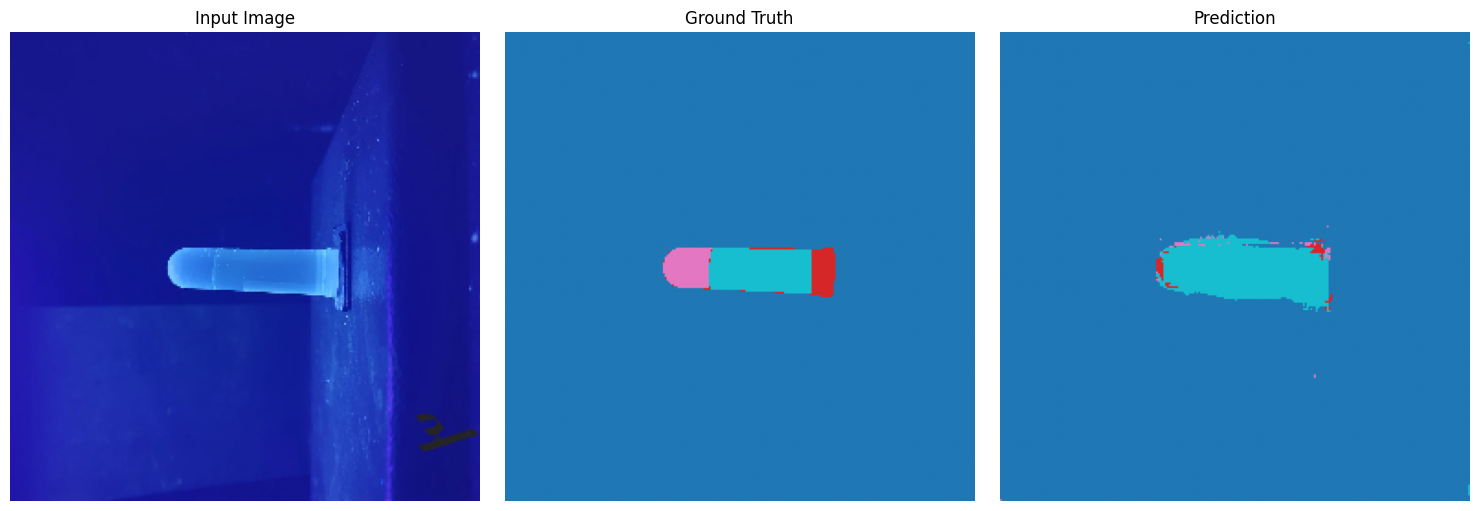

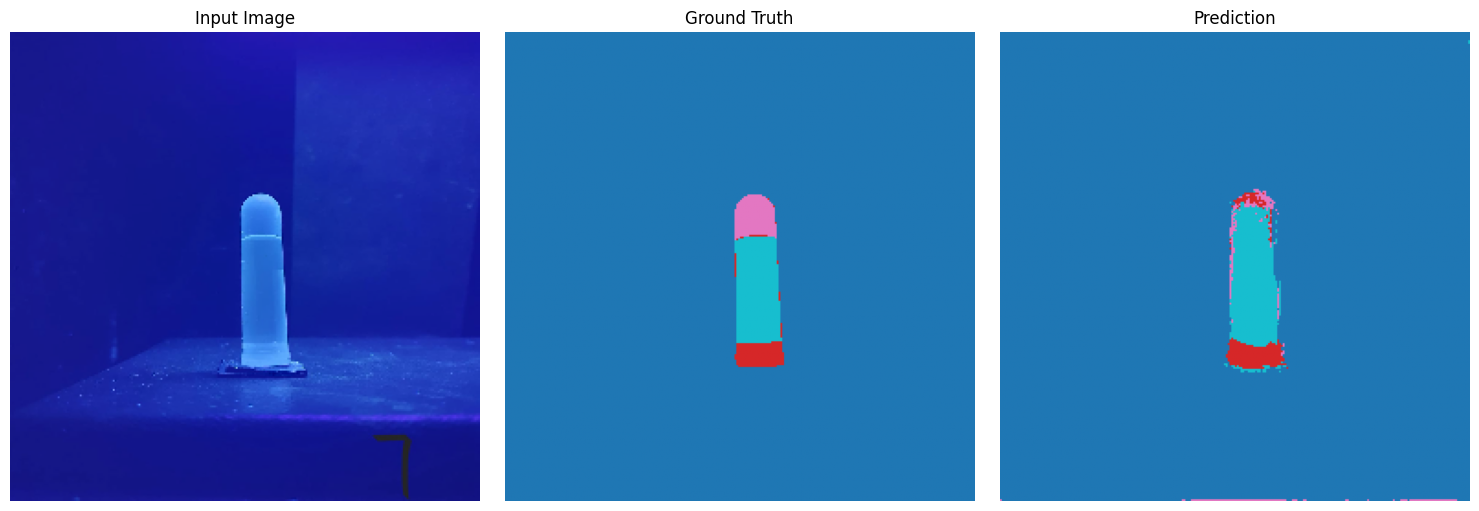


Predicting on images in: /home/noob/koty/new_before_last/project-ano/images-all
Saved prediction: /home/noob/koty/new_before_last/project-ano/multiclass_predictions/76_prediction.png
Saved prediction: /home/noob/koty/new_before_last/project-ano/multiclass_predictions/65_prediction.png
Saved prediction: /home/noob/koty/new_before_last/project-ano/multiclass_predictions/35_prediction.png
Saved prediction: /home/noob/koty/new_before_last/project-ano/multiclass_predictions/63_prediction.png
Saved prediction: /home/noob/koty/new_before_last/project-ano/multiclass_predictions/38_prediction.png
Saved prediction: /home/noob/koty/new_before_last/project-ano/multiclass_predictions/64_prediction.png
Saved prediction: /home/noob/koty/new_before_last/project-ano/multiclass_predictions/23_prediction.png
Saved prediction: /home/noob/koty/new_before_last/project-ano/multiclass_predictions/8_prediction.png
Saved prediction: /home/noob/koty/new_before_last/project-ano/multiclass_predictions/51_predicti

In [3]:
#!/usr/bin/env python
# coding: utf-8

# Install required packages
# pip install segmentation-models-pytorch matplotlib albumentations[imgaug] torchvision ipywidgets charset_normalizer

import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

# Define class mapping
NUM_CLASSES = 4
CLASS_NAMES = ['background', 'Eppendorf', 'empty_part', 'important_liquid']

class MultiClassSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_name)
        mask_name = os.path.splitext(image_name)[0] + "_mask.png"
        mask_path = os.path.join(self.mask_dir, mask_name)

        # Load image
        image = Image.open(image_path).convert("RGB")
        
        # Load mask - multi-class mask with values 0-3
        mask = Image.open(mask_path).convert("L")
        mask = np.array(mask)
        
        # Ensure mask values are in valid range [0, NUM_CLASSES-1]
        mask = np.clip(mask, 0, NUM_CLASSES-1)

        # Convert to numpy arrays for albumentations
        image = np.array(image)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        # Convert mask to long tensor for CrossEntropyLoss
        mask = torch.tensor(mask, dtype=torch.long)
        
        return image, mask

# Define transforms
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # ImageNet normalization
    ToTensorV2()
])

# Multi-class Dice Loss
class MultiClassDiceLoss(nn.Module):
    def __init__(self, num_classes=4, smooth=1):
        super(MultiClassDiceLoss, self).__init__()
        self.num_classes = num_classes
        self.smooth = smooth

    def forward(self, preds, targets):
        # preds: [B, C, H, W] - raw logits
        # targets: [B, H, W] - class indices
        
        # Apply softmax to get probabilities
        preds = F.softmax(preds, dim=1)
        
        # Convert targets to one-hot encoding
        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes).permute(0, 3, 1, 2).float()
        
        dice_losses = []
        for c in range(self.num_classes):
            pred_c = preds[:, c]
            target_c = targets_one_hot[:, c]
            
            intersection = (pred_c * target_c).sum()
            union = pred_c.sum() + target_c.sum()
            
            dice = (2. * intersection + self.smooth) / (union + self.smooth)
            dice_losses.append(1 - dice)
        
        return torch.stack(dice_losses).mean()

# Combined loss function
def combined_loss(preds, targets):
    ce_loss = nn.CrossEntropyLoss()(preds, targets)
    dice_loss = MultiClassDiceLoss()(preds, targets)
    return ce_loss + dice_loss

# Calculate IoU for each class
def calculate_iou(preds, targets, num_classes=4):
    ious = []
    preds = torch.argmax(preds, dim=1)  # Convert to class predictions
    
    for c in range(num_classes):
        pred_c = (preds == c)
        target_c = (targets == c)
        
        intersection = (pred_c & target_c).sum().float()
        union = (pred_c | target_c).sum().float()
        
        if union == 0:
            iou = 1.0  # Perfect score if both are empty
        else:
            iou = intersection / union
        ious.append(iou.item())
    
    return ious

# Setup dataset and data loaders
project_path = '/home/noob/koty/new_before_last/project-ano/'

full_dataset = MultiClassSegmentationDataset(
    project_path + "shit", 
    project_path + "masks-shit", 
    transform=transform
)

# Split dataset
train_size = int(0.5 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Initialize model for multi-class segmentation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,  # 4 classes instead of 1
    activation=None,  # No activation, we'll use softmax in loss
)
model.to(device)

# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=5,
    #verbose=True
)

num_epochs = 50

print("Starting multi-class training...")
print(f"Classes: {CLASS_NAMES}")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)  # [B, H, W] with class indices
        
        outputs = model(images)  # [B, C, H, W]
        loss = combined_loss(outputs, masks)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        # Calculate pixel accuracy
        preds = torch.argmax(outputs, dim=1)
        train_correct += (preds == masks).sum().item()
        train_total += masks.numel()
    
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = train_correct / train_total
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    all_ious = [[] for _ in range(NUM_CLASSES)]
    
    with torch.no_grad():
        for val_images, val_masks in val_loader:
            val_images = val_images.to(device)
            val_masks = val_masks.to(device)
            
            val_outputs = model(val_images)
            loss_val = combined_loss(val_outputs, val_masks)
            val_loss += loss_val.item()
            
            # Calculate accuracy
            val_preds = torch.argmax(val_outputs, dim=1)
            val_correct += (val_preds == val_masks).sum().item()
            val_total += val_masks.numel()
            
            # Calculate IoU for each class
            batch_ious = calculate_iou(val_outputs, val_masks)
            for i, iou in enumerate(batch_ious):
                all_ious[i].append(iou)
    
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    
    # Calculate mean IoU for each class
    mean_ious = [np.mean(class_ious) if class_ious else 0 for class_ious in all_ious]
    overall_miou = np.mean(mean_ious)
    
    scheduler.step(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train - Loss: {avg_train_loss:.4f}, Acc: {train_accuracy:.4f}")
    print(f"  Val   - Loss: {avg_val_loss:.4f}, Acc: {val_accuracy:.4f}, mIoU: {overall_miou:.4f}")
    print(f"  Class IoUs: {[f'{CLASS_NAMES[i]}: {iou:.3f}' for i, iou in enumerate(mean_ious)]}")
    print("-" * 80)

# Visualization function
def visualize_predictions(model, data_loader, num_samples=3):
    model.eval()
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(data_loader):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            images = images.cpu()
            masks = masks.cpu()
            preds = preds.cpu()
            
            for i in range(min(num_samples, images.shape[0])):
                fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                
                # Original image (denormalize)
                img = images[i].permute(1, 2, 0)
                img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
                img = torch.clamp(img, 0, 1)
                axs[0].imshow(img)
                axs[0].set_title("Input Image")
                
                # Ground truth
                axs[1].imshow(masks[i], cmap='tab10', vmin=0, vmax=NUM_CLASSES-1)
                axs[1].set_title("Ground Truth")
                
                # Prediction
                axs[2].imshow(preds[i], cmap='tab10', vmin=0, vmax=NUM_CLASSES-1)
                axs[2].set_title("Prediction")
                
                for ax in axs:
                    ax.axis("off")
                
                plt.tight_layout()
                plt.show()
            
            if batch_idx == 0:  # Only show first batch
                break

# Visualize some predictions
print("\nVisualizing predictions...")
visualize_predictions(model, val_loader, num_samples=2)

# Inference function for new images
def predict_image(model, image_path, transform, device):
    """Predict segmentation mask for a single image"""
    model.eval()
    
    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    original_size = image.size
    
    # Apply transforms
    image_np = np.array(image)
    transformed = transform(image=image_np)
    input_tensor = transformed['image'].unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
        pred_mask = torch.argmax(output, dim=1)[0].cpu().numpy()
    
    # Resize back to original size
    pred_mask_pil = Image.fromarray(pred_mask.astype(np.uint8))
    pred_mask_resized = pred_mask_pil.resize(original_size, Image.NEAREST)
    
    return np.array(pred_mask_resized), original_size

# Batch prediction function
def predict_directory(input_dir, output_dir, model, transform, device):
    """Predict segmentation masks for all images in a directory"""
    os.makedirs(output_dir, exist_ok=True)
    
    model.eval()
    
    for filename in os.listdir(input_dir):
        if not filename.lower().endswith((".png", ".jpg", ".jpeg")):
            continue
        
        image_path = os.path.join(input_dir, filename)
        pred_mask, original_size = predict_image(model, image_path, transform, device)
        
        # Save prediction mask
        name, _ = os.path.splitext(filename)
        mask_path = os.path.join(output_dir, f"{name}_prediction.png")
        Image.fromarray(pred_mask.astype(np.uint8)).save(mask_path)
        
        # Create colorized version
        colored_mask = create_colored_mask(pred_mask)
        colored_path = os.path.join(output_dir, f"{name}_colored.png")
        colored_mask.save(colored_path)
        
        print(f"Saved prediction: {mask_path}")

def create_colored_mask(mask):
    """Create a colorized version of the mask"""
    colors = [
        (0, 0, 0),       # Background - Black
        (255, 0, 0),     # Eppendorf - Red
        (0, 255, 0),     # empty_part - Green
        (0, 0, 255),     # important_liquid - Blue
    ]
    
    height, width = mask.shape
    colored_mask = np.zeros((height, width, 3), dtype=np.uint8)
    
    for class_id, color in enumerate(colors):
        colored_mask[mask == class_id] = color
    
    return Image.fromarray(colored_mask)

# Example usage for batch prediction
input_dir = "/home/noob/koty/new_before_last/project-ano/images-all"
output_dir = "/home/noob/koty/new_before_last/project-ano/multiclass_predictions"

if os.path.exists(input_dir):
    print(f"\nPredicting on images in: {input_dir}")
    predict_directory(input_dir, output_dir, model, transform, device)
    print(f"Predictions saved to: {output_dir}")
else:
    print(f"Input directory not found: {input_dir}")

# Save the trained model
model_path = os.path.join(project_path, "multiclass_segmentation_model.pth")
torch.save(model.state_dict(), model_path)
print(f"Model saved to: {model_path}")